## Praca domowa 3, WUM 
* Autor: Piotr Nawrot
* Data: 26.03.2021

## Do rozwiązania zadania 3 używam tych samych danych co w zadaniu 1 więc pozwoliłem sobie zostawić już poczynione obserwacje i opisy. Konkretnie rozwiązane podpunkty zadania 3 znajdują się na dole, po części z zadania 1.

# Problem Portugalskiego banku i oferty lokat terminowych

* Celem zadania jest zbudowanie modelu, który na podstawie historycznych danych określi czy klient zechce założyć lokatę w naszym portugalskim banku.
* Od predykcji modelu będzie zależała strategia banku, na podstawie prawdopodobieństwa skorzystania z oferty przez potencjalnego klienta pracownicy banku będą decydować czy warto się z nim kontaktować.
    * Z tego powodu będziemy optymalizować metrykę ROC_AUC
* Dane użyte w poniższym notebooku są oparte o https://archive.ics.uci.edu/ml/datasets/bank+marketing 
    * Jedyna modyfikacja danych polega na tym, że zostało usunięte kilka kolumn celem utrudnienia zadania - w danych wyjściowo był dosyć duży leak, a mianowicie kolumna z czasem ostatniej rozmowy banku z klientem. 
    * Czas tej rozmowy miał bardzo dużą korelację z faktem założenia lokaty. 

## Wczytanie danych i zaimportowanie bibliotek, nic ciekawego

In [12]:
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [13]:
full_dataset = pd.read_csv('bank-classification.csv')
print(full_dataset.shape)
data_len = full_dataset.shape[0]

(41188, 15)


## Opis danych

* birth_date - self-explainable 
* job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired', 'self- employed','services','student','technician','unemployed','unknown') 
* marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) 
* education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') 
* default: has credit in default? (categorical: 'no','yes','unknown') 
* housing: has housing loan? (categorical: 'no','yes','unknown') 
* loan: has personal loan? (categorical: 'no','yes','unknown') 

* contact_date: ostatnia data kontaktu 
* contact: contact communication type (categorical: 'cellular','telephone') 

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) 
* previous: number of contacts performed before this campaign and for this client (numeric) 
* poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') 

In [14]:
full_dataset.head()

,id,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
0,1,1952-03-23,housemaid,married,basic.4y,no,no,no,2008-05-12,telephone,1,999,0,nonexistent,no
1,2,1951-03-24,services,married,high.school,unknown,no,no,2008-05-26,telephone,1,999,0,nonexistent,unknown
2,3,1971-05-19,services,married,high.school,no,yes,no,2008-05-05,telephone,1,999,0,nonexistent,no
3,4,1968-01-24,admin.,married,basic.6y,no,no,no,2008-05-19,telephone,1,999,0,nonexistent,unknown
4,5,1952-05-11,services,married,high.school,no,no,yes,2008-05-19,telephone,1,999,0,nonexistent,unknown


### Data anylysis

Ciekawe obserwacje:
* Uczniowie i emeryci zakładają stosunkowo więcej lokat niż pozostali, ma to trochę sensu, Ci ludzie nie mają kredytów i losowych wydatków
* Osoby w związkach zakładają ciut mniej lokat niż single, możliwe, że wynika także z kredytów/wydatków na dzieci
* Jeśli ktoś ma problemy ze spłatą kredytu to raczej nie zakłada lokaty, to może być ważny czynnik
* Jeśli kontaktujemy się z kimś przez telefon komórkowy a nie stacjonarny to mamy większą szansę na wzięcie kredytu
* Jeśli ktoś wcześniej korzystał z usług banku, to na pewno warto do niego zadzwonić

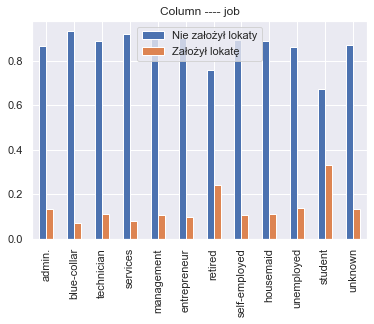

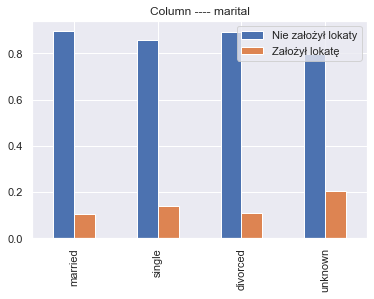

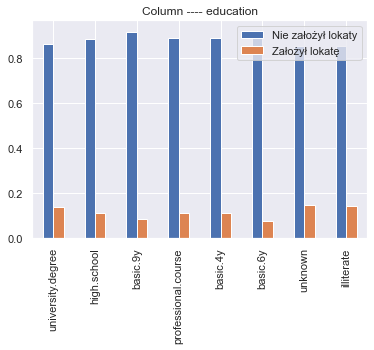

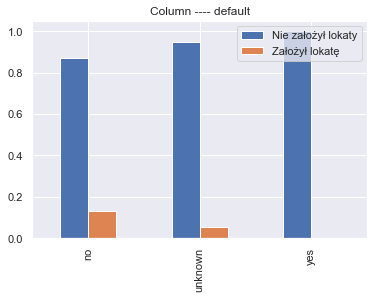

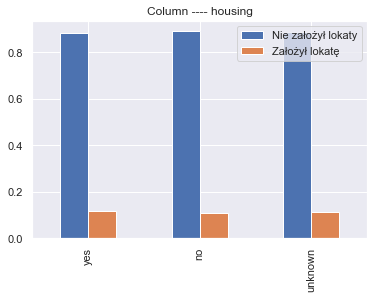

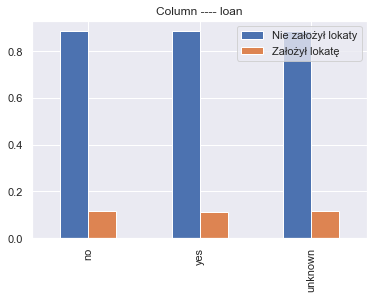

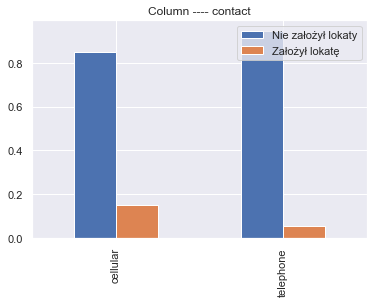

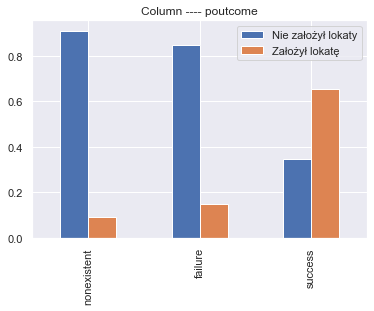

In [15]:
data = full_dataset.copy()

def plot_bar(column):
    df = pd.DataFrame()
    df['Nie założył lokaty'] = data[data['y'] == 'no'][column].value_counts()
    df['Założył lokatę'] = data[data['y'] == 'yes'][column].value_counts()
    df = df.div(df.sum(axis=1), axis=0)
    df.plot.bar(title = 'Column ---- {}'.format(column))
    plt.show()

for feature in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']:
    plot_bar(feature)

* Spójrzmy jeszcze na wiek, skoro wcześniej zauważyliśmy że emeryci i studenci częściej biorą kredyty to powinno to się też potwierdzić pod kątem wieku
    * I rzeczywiście, potwierdza się:
        * Dla osób poniżej 19 roku życia i po 58 wskaźnik wzięcia lokaty jest znacząco wyższy na poziomie >35% podczas gdy dla osób w średnim wieku wynik wacha się w okolicach 10-15%

In [16]:
data = full_dataset.copy()
data['birth_date'] = pd.to_datetime(data['birth_date'])
data['contact_date'] = pd.to_datetime(data['contact_date'])
age = (data['contact_date'] - data['birth_date']).dt.days // 365

l = 0

def count_yes_ratio(mask):
    data_subset = data[mask]
    yes = (data_subset.y == 'yes').sum()
    no = (data_subset.y == 'no').sum()
    return yes / (yes + no)

for idx, quantile in enumerate([0.002, 0.03, 0.1, 0.4, 0.7, 0.96, 1]):
    r = int(age.quantile(quantile))
    mask = ((age > l) & (age <= r))
    score = count_yes_ratio(mask)
    print(f'Quantile of {quantile} equals to: {age.quantile(quantile)}. \n'  
            f'Score for this group eqauls to: {score} \n' + 
            f'Group contains of {mask.sum()} members. \n')
    l = r

Quantile of 0.002 equals to: 19.0. 
Score for this group eqauls to: 0.41818181818181815 
Group contains of 107 members. 

Quantile of 0.03 equals to: 24.0. 
Score for this group eqauls to: 0.1987281399046105 
Group contains of 1249 members. 

Quantile of 0.1 equals to: 28.0. 
Score for this group eqauls to: 0.1480637813211845 
Group contains of 3534 members. 

Quantile of 0.4 equals to: 35.0. 
Score for this group eqauls to: 0.10900095754867539 
Group contains of 12456 members. 

Quantile of 0.7 equals to: 45.0. 
Score for this group eqauls to: 0.0866067203028869 
Group contains of 12484 members. 

Quantile of 0.96 equals to: 58.0. 
Score for this group eqauls to: 0.09528565721134638 
Group contains of 9902 members. 

Quantile of 1 equals to: 97.0. 
Score for this group eqauls to: 0.3516042780748663 
Group contains of 1456 members. 



### Data preprocessing

* Pomimo tego, że poniższy data processing jest ogromny, to nie ma tutaj nic specjalnie wartego uwagi
* Wyciągnałem kilka featurów z daty kontaktu, takie jak miesiąc, rok, dzień miesiąca i tygodnia
* Wyciągnąłem wiek klienta
* Zmapowałem kategorie na inty żeby były odpowiednim wejściem do modelu w sposób mniej lub bardziej arbitralny

In [127]:
from sklearn.preprocessing import StandardScaler

data = full_dataset.copy()
data['birth_date'] = pd.to_datetime(data['birth_date'])
data['contact_date'] = pd.to_datetime(data['contact_date'])

def calculate_age(data):
    data['age'] = (data['contact_date'] - data['birth_date']).dt.days // 365
#     data['age'] = pd.qcut(data['age'], 10, labels=False, duplicates = 'drop')
    return data

data = calculate_age(data)

data['contact_year'] = data.contact_date.dt.year
data['contact_month'] = data.contact_date.dt.month
# data['contact_day_of_month'] = data.contact_date.dt.day
# data['contact_day_of_week'] = data.contact_date.dt.dayofweek

# data['job_cat'] = data['job'].map({'admin.': 8,
#                                     'blue-collar': 0,
#                                     'entrepreneur': 2,
#                                     'housemaid': 5,
#                                     'management': 3,
#                                     'retired': 10,
#                                     'self-employed': 4,
#                                     'services': 1,
#                                     'student': 11,
#                                     'technician': 6,
#                                     'unemployed': 9,
#                                     'unknown': 7}).astype('uint8')

# data['marital_cat'] = data['marital'].map({'married': 0, 'divorced': 1, 'single': 2, 'unknown': 0}).astype('uint8')

# data['education_cat'] = data['education'].map({'basic.6y': 0, 'basic.9y': 1, 'basic.4y': 2, 'professional.course': 3, 
#                                                'high.school': 4, 'university.degree': 5, 'illiterate': -1, 'unknown': 6}).astype('uint8')

# data['default_cat'] = data['default'].map({'no': 0, 'yes': 1, 'unknown': 2}).astype('uint8')

# data['housing_cat'] = data['housing'].map({'no': 0, 'yes': 1, 'unknown': 2}).astype('uint8')

# data['loan_cat'] = data['loan'].map({'no': 0, 'yes': 1, 'unknown': 2}).astype('uint8')

# data['contact_cat'] = data['contact'].map({'telephone': 0, 'cellular': 1}).astype('uint8')

# data['poutcome_cat'] = data['poutcome'].map({'nonexistent': 0, 'failure': 1, 'success': 2}).astype('uint8')

# data['some_loan'] = ((data['loan_cat'] == 1) | (data['housing_cat'] == 1) | (data['default_cat'] == 1)).astype('uint8')

columns_to_onehot = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
data = pd.get_dummies(data, prefix=columns_to_onehot, columns=columns_to_onehot)

columns_to_drop = ['id', 'birth_date', 'contact_date'] 
data = data.drop(columns_to_drop, axis = 1)

np.random.seed(42)

train_set = data.copy()[data['y'] != 'unknown']
train_set.loc[:, 'y'] = train_set.y.map({'no':0.0, 'yes':1.0}).astype('float')

test_set = data.copy()[data['y'] == 'unknown'].drop('y', axis = 1)

X = train_set.copy().drop('y', axis = 1)
X = X.reset_index(drop=True)
# X_not_normalized = X.copy()
# X = (X - X.mean() ) / X.std()
y = train_set.copy()['y'].to_numpy()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Spójrzmy na feature importance, może dowiemy się czegoś nowego

<AxesSubplot:title={'center':'Feature importance - first glance'}, ylabel='cols'>

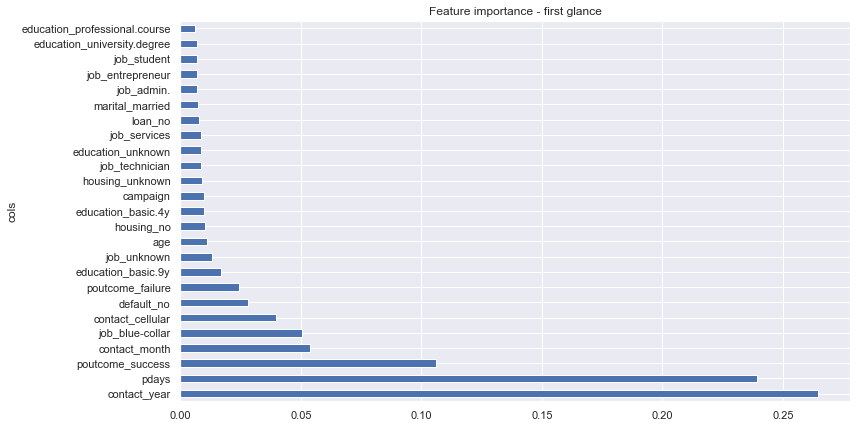

In [130]:
model = XGBClassifier()
model.fit(X, y)
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi, title=None): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, title=title)
fi = rf_feat_importance(model, X)
plot_fi(fi[:25], title="Feature importance - first glance")

* Rok kontaktu ma ogromne znaczenie - rzeczywiście dane są z okresu 2008-2010
    * 2008 - 0.049353617598742947
    * 2009 - 0.19854343679556094
    * 2010 - 0.527643064985451
    * Albo rolę gra kryzys finansowy, albo bank uczy się na swoich błędach i udoskonala swoje metody
* Ogromne znaczenie mają też dane na temat poprzedniej kampanii - pdays i poutcome
* Dalej ważne były kategorie o których myśleliśmy na począktu takie jak forma kontaktu, czy problemy ze spłatą kredytu, ponad to jeszcze zatrudnienie
* Co ciekawe ważny jest też w tym wszystkim miesiąc kontaktu

In [131]:
def count_yes_ratio(mask):
    data_subset = data[mask]
    yes = (data_subset.y == 'yes').sum()
    no = (data_subset.y == 'no').sum()
    return yes / (yes + no)

for year in range(2008, 2011):
    print(year, count_yes_ratio(data['contact_year'] == year))

2008 0.049353617598742947
2009 0.19854343679556094
2010 0.527643064985451


### Rzeczywisty początek drugiej pracy domowej

# Punkt 2.1 - wytrenowanie modelu GBM

In [143]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
print('Cross validation score with 5 stratified folds is eval to {}'.format(cross_val_score(model, X, y, scoring='roc_auc', cv=cv).mean()))

Cross validation score with 5 stratified folds is eval to 0.7503674304898282


In [144]:
model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Punkt 2.2 - For some selected observations from this dataset, calculate predictions for model

Obliczam predykcje dla obserwacji ze zbioru treningowego, danych było 40 tysięcy obserwacji a to wydaje się być względnie duża liczba w przypadku modeli machine learningowych opartych na danych tabularycznych (z małą ilością cech) więc przyjmuję mały wpływ tego, że dana obserwacja była widziana przez model.

* Wylosowałem trzy przykłady, w taki sposób żeby co najmniej jeden z wylosowanych klientów skorzystał z oferty i założył lokatę
* Predykcje modelu wyglądają okej, zgadzają się z rzeczywistymi labelami

In [145]:
n_samples = 3
indexes = np.random.randint(low=0, high=X.shape[0], size=(n_samples))
while not (y[indexes] == 1).any():
    indexes = np.random.randint(low=0, high=X.shape[0], size=(n_samples))
sample_observations = X.iloc[indexes]
final_outcomes_from_sample_observations = y[indexes]
full_dataset[full_dataset['y'] != 'unknown'].reset_index().iloc[indexes].head(n=n_samples)

,index,id,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
13716,27142,27143,1961-03-23,admin.,married,university.degree,no,no,no,2008-11-28,cellular,1,999,0,nonexistent,no
6981,13737,13738,1976-07-29,unknown,single,professional.course,no,no,no,2008-07-10,cellular,1,999,0,nonexistent,yes
6376,12615,12616,1981-06-09,admin.,married,high.school,no,yes,no,2008-07-28,cellular,2,999,0,nonexistent,no


In [146]:
model_predictions = model.predict_proba(sample_observations)
print(model_predictions)

[[1.   0.  ]
 [0.31 0.69]
 [0.99 0.01]]


# Punkt 2.3 - for observations selected in (2), calculate the decomposition of model prediction using LIME

* Z tego jak rozumiem metodę LIME i co się dzieje under the hood to:
    * Moje dane są mocno niedostosowane do typowego samplowania i liczenia odległości
        * Dużo zmiennych kategorycznych dla których liczenie odległości nie ma sensu
        * Dla przykładu odległość pomiędzy zatrudnieniem, a wiekiem jest inna
        * Z tego powodu skorzystam z dyskretyzacji, podzielę dane na 4 części - QuartileDiscretizer
        * Dodatkowo zmieniłem większość kolumn, które były zmiennymi kategorycznymi ale przedstawione w sposób mapowania na inty w jednej kolumnie na one-hot
    * Wybieram metodę wyboru featurów forward selection
        * Highest weights po zdyskretyzowaniu zmiennych ciągłych powinna działać podobnie, ale wciąż niektóre kolumny mają wartości [0, 1], a niektóre [0,1,2,3]
        * Wydaje mi się, że przez tę różnicę highest weights czasami może być bardziej biased niż forward selection, ale nie jestem w 100% pewien
    * Num-samples empricznie sprawdziłem, że nie potrzeba ich 5000, wystarczy około 1000
        * Im więcej sampli tym LIME jest bardziej "stabilny" - przynajmniej pod tym kątem, że uruchomiony kilka razy generuje podobny model K-lasso
        * Dla 1000 sampli pierwsze trzy najważniejsze cechy zostają takie same gdy uruchamiamy model kilka razy
    * Generuje tylko 5 najważniejszych featureów metodą K-Lasso
        * Więcej powoduje niewytłumaczalny overfitting
            * Biorąc pod uwagę, że LIME generuje dane z pełnego rozkładu, a nie skupia się na najbliższym sobie otoczeniu (to znaczy skupia się, ważeniem obserwacji, ale mimo wszystko istnieją dane mniej podobne mające wpływ na budowowany model) to przypisywanie wag bardzo szczegółowym kategoriom brzmi jak overfitting

In [227]:
from lime.lime_tabular import LimeTabularExplainer 
explainer = LimeTabularExplainer(X.to_numpy(), 
                                 feature_names=X.columns, 
                                 class_names=['rejected', 'accepted'], 
                                 discretize_continuous=True, 
                                 mode='classification',
                                 feature_selection='forward_selection',
                                 sample_around_instance=False,
                                 random_state=0)

In [228]:
sample_observations.iloc[:1]

,campaign,pdays,previous,age,contact_year,contact_month,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
13716,1,999,0,47,2008,11,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0


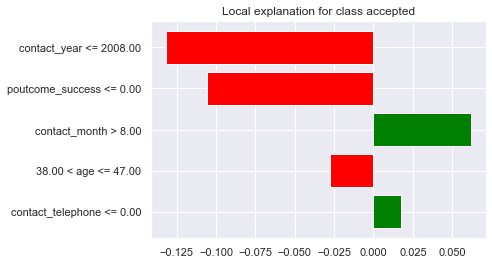

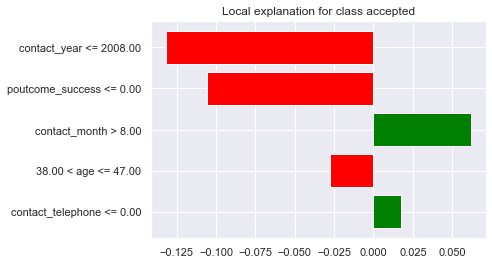

In [231]:
lime = explainer.explain_instance(sample_observations.iloc[0], model.predict_proba, num_features=5, num_samples=1000)
lime.as_pyplot_figure()

In [232]:
sample_observations.iloc[1:2]

,campaign,pdays,previous,age,contact_year,contact_month,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
6981,1,999,0,31,2008,7,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


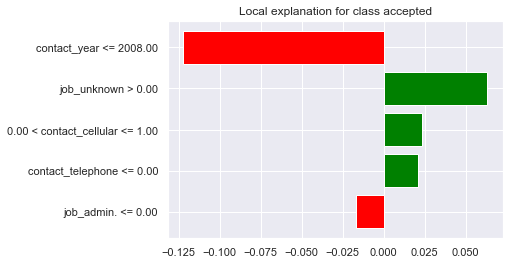

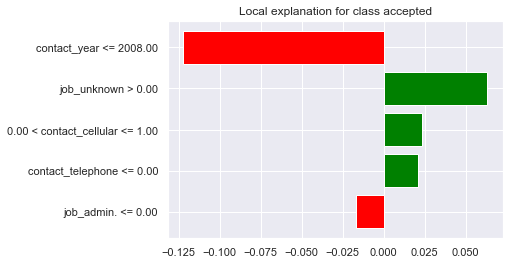

In [233]:
lime = explainer.explain_instance(sample_observations.iloc[1], model.predict_proba, num_features=5, num_samples=1000)
lime.as_pyplot_figure()

# Punkt 2.4 - Compare LIME decompositions for different observations in the dataset. How stable are these explanations?

* Stabilność LIME:
    * Num_samples:
        * Jeśli mamy num_samples > 1000, to wielokrotne generowanie modele dla różnych obserwacji są bardzo podobne   
    * Wagi zmiennych dla różnych obserwacji - w różnych miejscach przestrzeni obserwacji - inna lokalność
        * Na przykład dla dwóch przykładów z wcześniejszego zadania widać bardzo podobną wagę do parametru contact_year <= 2008 - sprawdźmy czy dla jeszcze większej liczby ten parametr zostaje taki sam
        * Tutaj korzystam z kawałku kodu kolegi @piotrdusz

In [250]:
n_samples = 200
indexes = np.random.randint(low=0, high=X.shape[0], size=(n_samples))
exp_dict = {}
for i in X.index[indexes]:
    exp = explainer.explain_instance(X.loc[i], model.predict_proba, num_features=5, num_samples=50)
    exp_dict_one_obs = {el[0]:el[1] for el in exp.as_list()}
    for k, v in exp_dict_one_obs.items():
        exp_dict.setdefault(k, []).append(v)

/Users/piotrnawrot/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.85333e-18): result may not be accurate.
  overwrite_a=True).T
/Users/piotrnawrot/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.66894e-18): result may not be accurate.
  overwrite_a=True).T
/Users/piotrnawrot/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.40947e-18): result may not be accurate.
  overwrite_a=True).T
/Users/piotrnawrot/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.16524e-18): result may not be accurate.
  overwrite_a=True).T
/Users/piotrnawrot/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.13774e-17): result may not be accurate.
  overw

In [251]:
exp_dict = dict(sorted(exp_dict.items(), key=lambda item: len(item[1]), reverse=True))

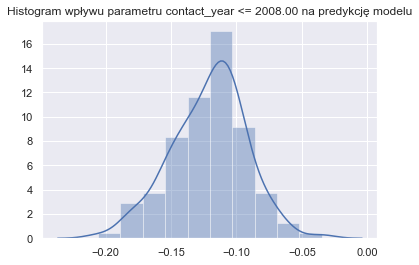

In [252]:
import seaborn as sns
keys = list(exp_dict.keys())
ax = sns.distplot(exp_dict[keys[0]], bins=10).set_title('Histogram wpływu parametru {} na predykcję modelu'.format(keys[0]))

* Rozkład wagi dla tego parametru przypomina rozkład normalny, wariancja jest dosyć spora, ale dalej w normie, wpływ tej zmiennej jest nieustannie ujemny więc jest okej

* Chciałbym przyjrzeć się jeszcze jednej sytuacji, wcześniej (2) wysamplowaliśmy obserwacje dla której model przewidział 60% na tak (model jest trochę biased z tego powodu że optymalizuje ROC AUC, 60% to jest równoznaczność przewidzenia tak) natomiast LIME nie potrafi zbliżyć się do tej predykcji i przewiduje 10-20%

In [262]:
explainer = LimeTabularExplainer(X.to_numpy(), 
                                 feature_names=X.columns, 
                                 class_names=['rejected', 'accepted'], 
                                 discretize_continuous=True, 
                                 mode='classification',
                                 feature_selection='forward_selection',
                                 sample_around_instance=False,
                                 random_state=0, 
                                 verbose=True)

In [263]:
sample_observations.iloc[1:2]

,campaign,pdays,previous,age,contact_year,contact_month,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
6981,1,999,0,31,2008,7,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


Intercept 0.27081633057994514
Prediction_local [0.22924975]
Right: 0.69


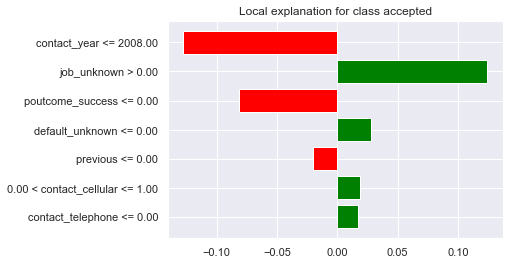

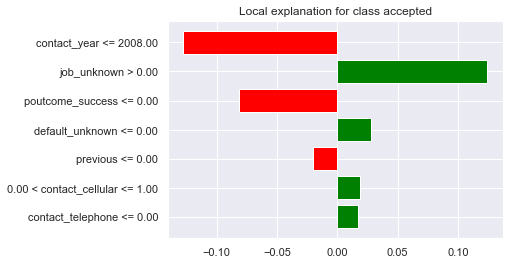

In [268]:
lime = explainer.explain_instance(sample_observations.iloc[1], model.predict_proba, num_features=7, num_samples=1000)
lime.as_pyplot_figure()

In [269]:
model.predict_proba(sample_observations.iloc[1:2])

array([[0.31, 0.69]])

In [277]:
tmp = sample_observations.iloc[1:2].copy()
tmp['job_unknown'] = 0
print(model.predict_proba(tmp))

[[0.85083333 0.14916667]]


* Lime nam pokazał, że job_unknown ma duże znaczenie w pobliżu tej obserwacji
* Zmieniłem więc job_unknown z tego wiersza na 0 i predykcja zmieniła się diametralnie - kompletnie się odwróciła
* To chyba świadczy o tym, że nasz model trochę tutaj za bardzo zoverfitował pod dane i nie powinniśmy mu za bardzo ufać...

# Punkt 2.5 - Train a second model (of any class, neural nets, linear, other boosting) and find an observation for which LIME attributions are different between the models

* Wytrenowałem znowu RandomForestClassifier, ale z ustaloną głębokością 7, raczej większą niż dotychczas
* Sprawdziłem tę samą obserwacje co poprzednio wskazywała na to, że poprzedni model zoverfitował
* Dla tego modelu predykcja bar

In [283]:
?RandomForestClassifier

<AxesSubplot:title={'center':'Feature importance - first glance'}, ylabel='cols'>

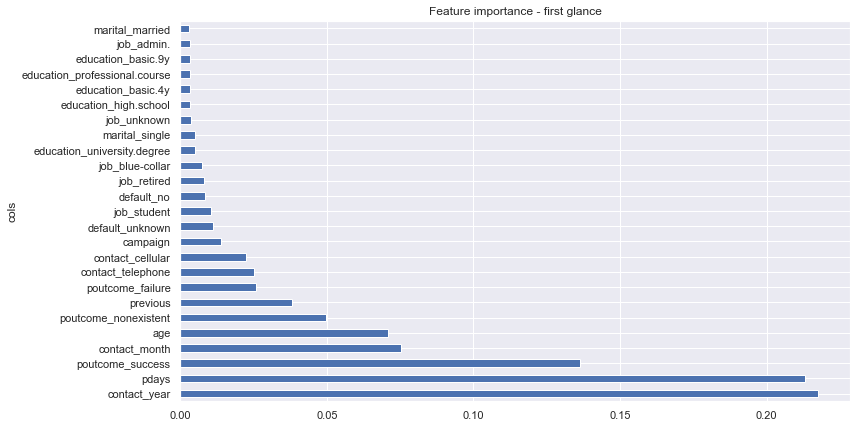

In [280]:
model = RandomForestClassifier(max_depth=7)
model.fit(X, y)
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi, title=None): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, title=title)
fi = rf_feat_importance(model, X)
plot_fi(fi[:25], title="Feature importance - first glance")

Intercept 0.24398382636547464
Prediction_local [0.09181718]
Right: 0.10307283387192971


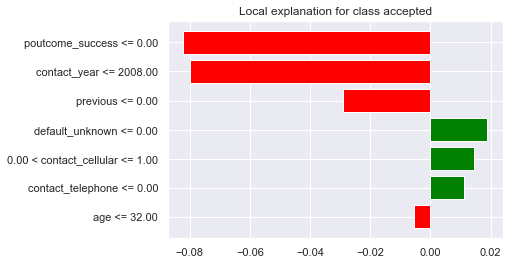

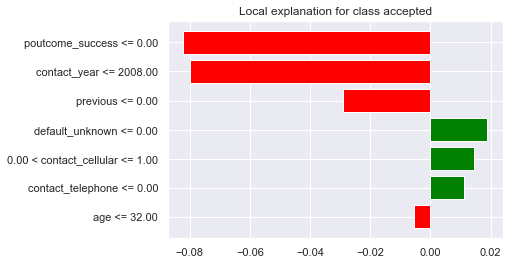

In [281]:
lime = explainer.explain_instance(sample_observations.iloc[1], model.predict_proba, num_features=7, num_samples=1000)
lime.as_pyplot_figure()